In [ ]:
# Step 1: Mount Google Drive (only needed if working in Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 2: Import Libraries
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

Initial Data Snapshot:
   id                          car_name          brand      car_model  \
0   1               Toyota Fielder 2011         Toyota        Fielder   
1   2                  Toyota Noah 2005         Toyota           Noah   
2   3               Toyota LiteAce 2001         Toyota        LiteAce   
3   4  Maruti Suzuki Vitara Brezza 1994  Maruti Suzuki  Vitara Brezza   
4   5          Toyota Starlet good 1992         Toyota        Starlet   

   model_year transmission  body_type fuel_type  engine_capacity  travels  \
0        2016    Automatic     Estate       CNG             1500    45852   
1        2010    Automatic  Hatchback       CNG             1998   219630   
2        2001       Manual        Van       CNG             1800   102000   
3        1994       Manual  Hatchback       CNG             1600   113000   
4        1992    Automatic     Saloon       CNG             1300    15000   

     price accident  registration  
0  1200000        N          2025  
1  

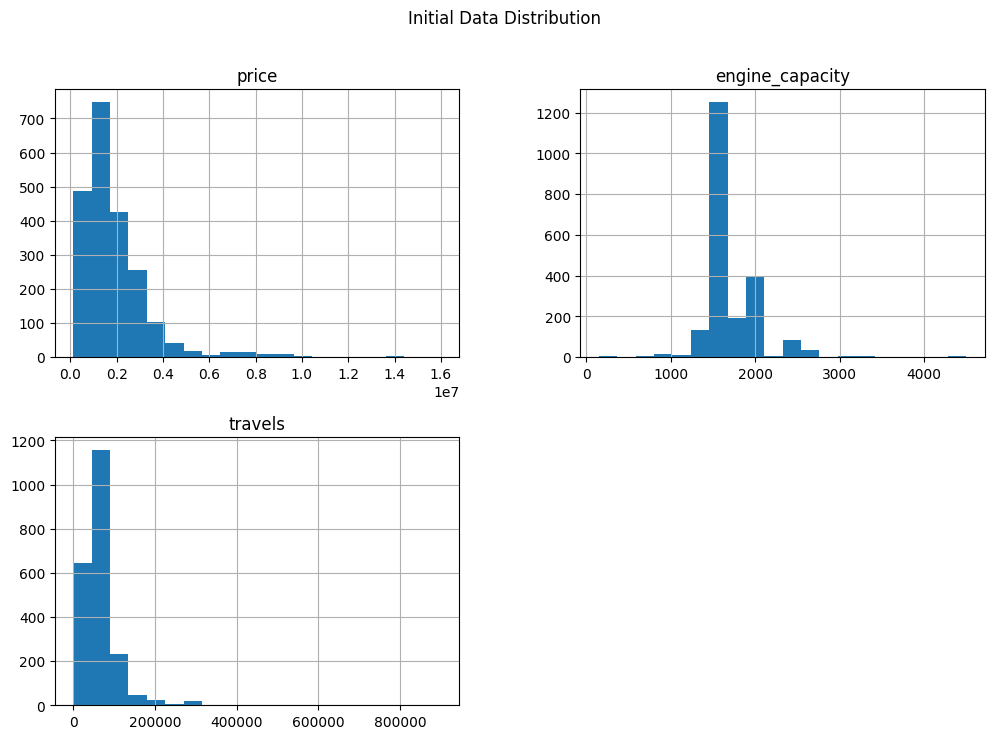

In [ ]:
# Step 3: Load the Dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/Bikroy_final.csv'
car_df = pd.read_csv(file_path, encoding='latin-1')

# Step 4: Display Initial Data
print("Initial Data Snapshot:")
print(car_df.head())
print("\nData Summary:")
print(car_df.info())

# Plot histogram of initial data for selected columns
car_df[['price', 'engine_capacity', 'travels']].hist(bins=20, figsize=(12, 8))
plt.suptitle("Initial Data Distribution")
plt.show()

<ipython-input-4-637b4078bad1>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  car_df[col].fillna(car_df[col].mode()[0], inplace=True)


Data Shape after Cleaning: (2137, 13)


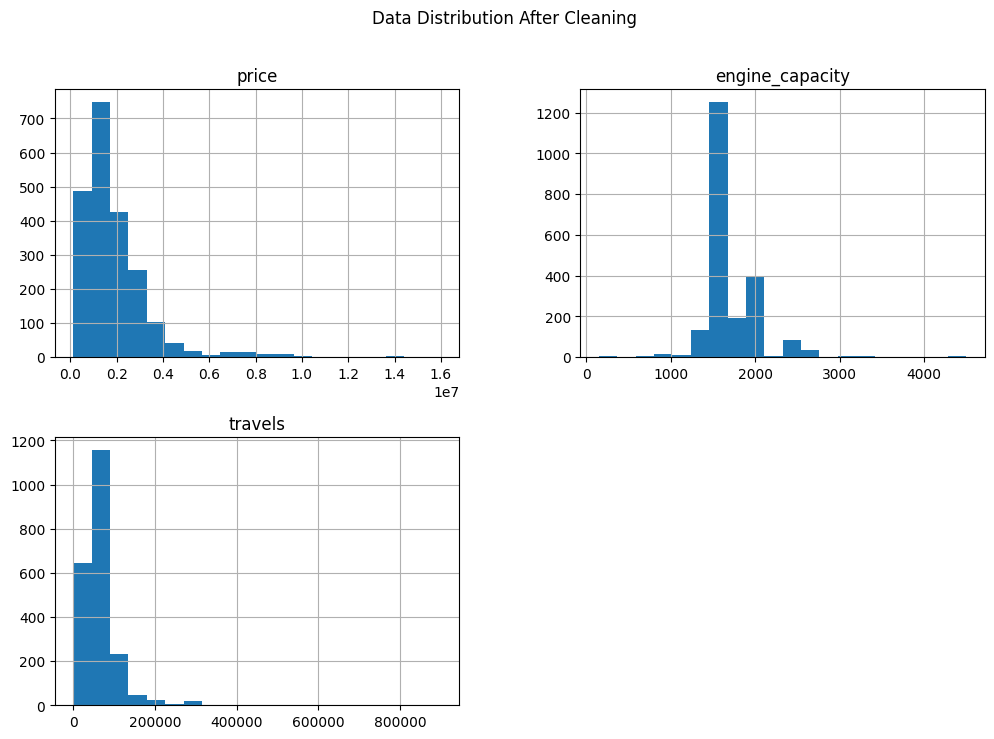

In [ ]:
# Handling Missing Values
car_df.isna().sum()  # Check missing values

# Drop rows with more than 5% missing values
car_df = car_df.dropna(thresh=len(car_df.columns) * 0.95)

# Fill categorical missing values with the most frequent category
for col in ['body_type', 'fuel_type']:
    car_df[col].fillna(car_df[col].mode()[0], inplace=True)

# Check and remove duplicates
car_df.drop_duplicates(keep='first', inplace=True)

# Verify final shape after preprocessing
print("Data Shape after Cleaning:", car_df.shape)

# Plot histogram after cleaning
car_df[['price', 'engine_capacity', 'travels']].hist(bins=20, figsize=(12, 8))
plt.suptitle("Data Distribution After Cleaning")
plt.show()


Processed Data Snapshot:
   id                          car_name fuel_type  engine_capacity  travels  \
0   1               Toyota Fielder 2011       CNG             1500    45852   
1   2                  Toyota Noah 2005       CNG             1998   219630   
2   3               Toyota LiteAce 2001       CNG             1800   102000   
3   4  Maruti Suzuki Vitara Brezza 1994       CNG             1600   113000   
4   5          Toyota Starlet good 1992       CNG             1300    15000   

     price  age age_category price_category engine_capacity_category  \
0  1200000    8          Old         Medium                   Medium   
1  1200000   14     Very Old         Medium                     High   
2   165000   23     Very Old            Low                     High   
3   230000   30     Very Old            Low                   Medium   
4   330000   32     Very Old            Low                      Low   

  travels_category  
0              Low  
1             High  
2   

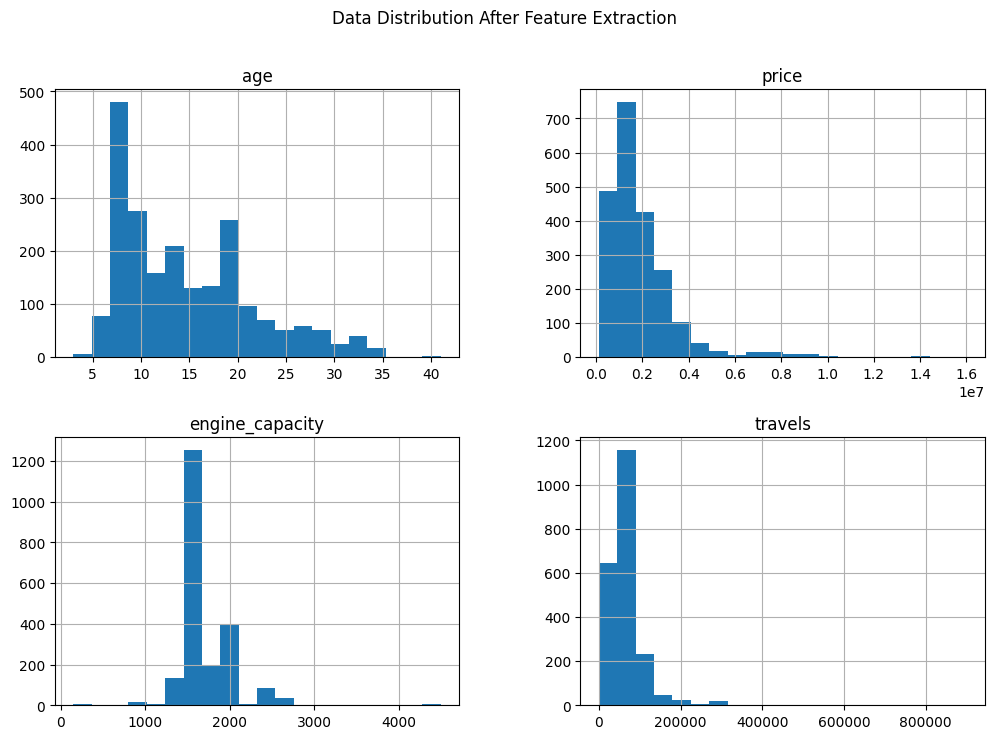

In [ ]:
from datetime import datetime

# Current year for calculating car age
current_year = datetime.now().year

# Feature Extraction Function
def preprocess_and_extract_features(df):
    # Calculate car age
    df['age'] = current_year - df['model_year']

    # Add Age Category
    age_bins = [0, 2, 5, 10, float('inf')]
    age_labels = ['New', 'Recent', 'Old', 'Very Old']
    df['age_category'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

    # Add Price Category
    price_bins = [0, df['price'].quantile(0.33), df['price'].quantile(0.66), df['price'].max()]
    df['price_category'] = pd.cut(df['price'], bins=price_bins, labels=['Low', 'Medium', 'High'])

    # Add Engine Capacity Category
    engine_bins = [0, 1499, 1799, float('inf')]
    df['engine_capacity_category'] = pd.cut(df['engine_capacity'], bins=engine_bins, labels=['Low', 'Medium', 'High'])

    # Add Travels Category
    travels_bins = [-1, 50000, 150000, float('inf')]
    travels_labels = ['Low', 'Medium', 'High']
    df['travels_category'] = pd.cut(df['travels'], bins=travels_bins, labels=travels_labels)


    # Drop columns not needed after extraction
    df = df.drop(columns=['transmission', 'body_type', 'brand', 'car_model', 'model_year', 'accident', 'registration'])

    return df

# Apply Feature Extraction
processed_df = preprocess_and_extract_features(car_df)
print("Processed Data Snapshot:")
print(processed_df.head())

# Plot histogram after feature extraction
processed_df[['age', 'price', 'engine_capacity', 'travels']].hist(bins=20, figsize=(12, 8))
plt.suptitle("Data Distribution After Feature Extraction")
plt.show()


TF-IDF Matrix (Dense Representation):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
TF-IDF Matrix Shape: (2137, 588)
Cosine Similarity Matrix:
[[1.         0.10320846 0.10992761 ... 0.02337118 0.09231181 0.09231181]
 [0.10320846 1.         0.15228615 ... 0.3129619  0.03381268 0.03381268]
 [0.10992761 0.15228615 1.         ... 0.12047088 0.042001   0.042001  ]
 ...
 [0.02337118 0.3129619  0.12047088 ... 1.         0.         0.        ]
 [0.09231181 0.03381268 0.042001   ... 0.         1.         0.61108936]
 [0.09231181 0.03381268 0.042001   ... 0.         0.61108936 1.        ]]
Cosine Similarity Matrix Shape: (2137, 2137)
Flattened Similarity Scores:
[1.         0.10320846 0.10992761 ... 0.         0.61108936 1.        ]


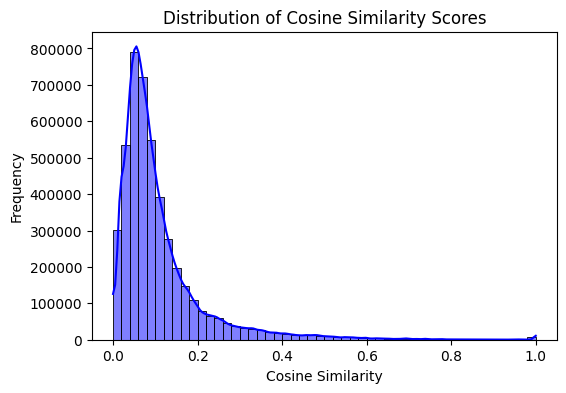

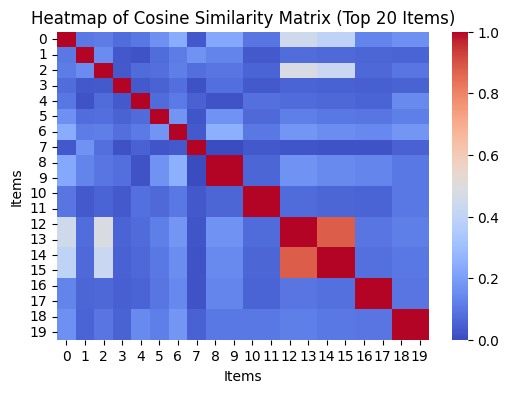

In [ ]:
# Combine Features for TF-IDF Vectorization
processed_df['combined_features'] = processed_df['car_name'] + ' ' + \
                                    processed_df['price_category'].astype(str) + ' ' + \
                                    processed_df['engine_capacity_category'].astype(str) + ' ' + \
                                    processed_df['travels_category'].astype(str)

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_df['combined_features'])

# Print the TF-IDF Matrix as an array
print("TF-IDF Matrix (Dense Representation):")
print(tfidf_matrix.toarray())  # Convert sparse matrix to dense for inspection

# Print the shape of the TF-IDF Matrix
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

# Compute Cosine Similarity
similarity_matrix = cosine_similarity(tfidf_matrix)

# Print the Cosine Similarity Matrix
print("Cosine Similarity Matrix:")
print(similarity_matrix)


# Compute Cosine Similarity
similarity_matrix = cosine_similarity(tfidf_matrix)
print("Cosine Similarity Matrix Shape:", similarity_matrix.shape)

# Flatten the similarity matrix to a 1D array
similarity_scores = similarity_matrix.flatten()
print("Flattened Similarity Scores:")
print(similarity_scores)

# Plot distribution of similarity scores
plt.figure(figsize=(6, 4))
sns.histplot(similarity_scores, kde=True, bins=50, color='blue')
plt.title("Distribution of Cosine Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()


import seaborn as sns
import matplotlib.pyplot as plt

# Plot a heatmap of the cosine similarity matrix
plt.figure(figsize=(6, 4))
sns.heatmap(similarity_matrix[:20, :20], cmap='coolwarm', annot=False)  # Limiting to first 20 items for clarity
plt.title("Heatmap of Cosine Similarity Matrix (Top 20 Items)")
plt.xlabel("Items")
plt.ylabel("Items")
plt.show()


Enter your preferred maximum price: 2000000
Enter preferred maximum age of the car: 10
Enter maximum kilometers traveled: 150000
Enter preferred minimum engine capacity (cc): 2500
Average Similarity Score (Accuracy): 76.55%


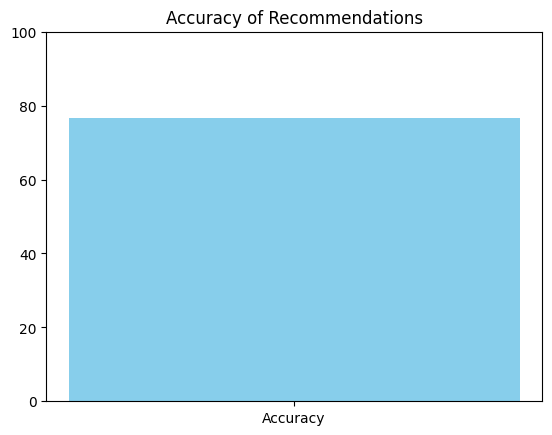

Recommendations Based on Buyer Preferences:
        id                               car_name    price  engine_capacity  \
831    832  Toyota Hiace GL DIESEL AMBULANCE 2015  1550000             3000   
1886  1887            Toyota Hiace Ambulance 2015  1390000             2000   
1885  1886            Toyota Hiace Ambulance 2015  1390000             2000   
1437  1438            Toyota Hiace AMBULANCE 2015   970000             1500   
826    827               Toyota Hiace Diesel 2005  1290000             2500   

      age  
831     9  
1886    9  
1885    9  
1437    9  
826    19  


In [ ]:
# Function to Get Buyer Preferences
def get_buyer_preferences():
    price = int(input("Enter your preferred maximum price: "))
    age = int(input("Enter preferred maximum age of the car: "))
    travels = int(input("Enter maximum kilometers traveled: "))
    engine_capacity = int(input("Enter preferred minimum engine capacity (cc): "))

    return {'price': price, 'age': age, 'travels': travels, 'engine_capacity': engine_capacity}

# Recommendation Function
def recommend_cars(df, similarity_matrix, buyer_preferences, top_n=5):
    filtered_cars = df[(df['price'] <= buyer_preferences['price']) &
                       (df['age'] <= buyer_preferences['age']) &
                       (df['travels'] <= buyer_preferences['travels']) &
                       (df['engine_capacity'] >= buyer_preferences['engine_capacity'])]

    # Find indices of filtered cars
    filtered_indices = filtered_cars.index
    avg_similarity_scores = similarity_matrix[filtered_indices].mean(axis=0)

    # Sort by similarity
    similar_cars_indices = avg_similarity_scores.argsort()[::-1][:top_n]
    recommended_cars = df.iloc[similar_cars_indices]

    # Calculate accuracy based on average similarity score
    avg_similarity_score = avg_similarity_scores[similar_cars_indices].mean()
    accuracy = avg_similarity_score * 100
    print(f"Average Similarity Score (Accuracy): {accuracy:.2f}%")

    # Plot accuracy
    plt.figure()
    plt.bar(["Accuracy"], [accuracy], color='skyblue')
    plt.ylim(0, 100)
    plt.title("Accuracy of Recommendations")
    plt.show()

    return recommended_cars[[ 'id','car_name', 'price', 'engine_capacity', 'age', ]]

# Get Buyer Preferences and Generate Recommendations
buyer_preferences = get_buyer_preferences()
recommendations = recommend_cars(processed_df, similarity_matrix, buyer_preferences)
print("Recommendations Based on Buyer Preferences:")
print(recommendations)
